In [2]:
import getFamaFrenchFactors as gff
import pandas as pd
import statsmodels.api as sm
import yfinance as yf
import numpy as np

In [11]:
#Walmart stock data
ticker = "WMT"
stock = yf.Ticker(ticker)
stockData = stock.history(period="max", auto_adjust=True)
stockData

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1972-08-25 00:00:00-04:00,0.034809,0.035478,0.034809,0.035344,2508800,0.0,0.0
1972-08-28 00:00:00-04:00,0.035344,0.035612,0.035210,0.035210,972800,0.0,0.0
1972-08-29 00:00:00-04:00,0.035076,0.035076,0.034809,0.034809,1945600,0.0,0.0
1972-08-30 00:00:00-04:00,0.034809,0.034809,0.034541,0.034809,409600,0.0,0.0
1972-08-31 00:00:00-04:00,0.034541,0.034541,0.034273,0.034273,870400,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-29 00:00:00-05:00,157.529999,158.080002,157.160004,157.649994,7314200,0.0,0.0
2024-01-02 00:00:00-05:00,157.250000,159.539993,157.190002,159.289993,7846600,0.0,0.0
2024-01-03 00:00:00-05:00,159.770004,160.300003,158.929993,159.300003,6252000,0.0,0.0


In [14]:
#stock returns calculation 
ret = stockData['Close'].resample('M').ffill().pct_change().dropna()
ret.name = 'Monthly_Return'
ret.index = pd.to_datetime(ret.index, format='%Y-%m-%d').date
ret

1972-09-30   -0.089839
1972-10-31    0.107285
1972-11-30    0.000000
1972-12-31    0.069776
1973-01-31   -0.141312
                ...   
2023-09-30   -0.016481
2023-10-31    0.021760
2023-11-30   -0.047243
2023-12-31    0.016350
2024-01-31   -0.005962
Name: Monthly_Return, Length: 617, dtype: float64

In [26]:
#Download FF3 factors
ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={'date_ff_factors' : 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)
ff3_monthly.index = pd.to_datetime(ff3_monthly.index, format='%Y%m').date
ff3_monthly

,Mkt-RF,SMB,HML,RF
1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1926-08-31,0.0264,-0.0117,0.0382,0.0025
1926-09-30,0.0036,-0.0140,0.0013,0.0023
1926-10-31,-0.0324,-0.0009,0.0070,0.0032
1926-11-30,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...
2023-07-31,0.0321,0.0208,0.0411,0.0045
2023-08-31,-0.0239,-0.0316,-0.0106,0.0045
2023-09-30,-0.0524,-0.0251,0.0152,0.0043
2023-10-31,-0.0319,-0.0387,0.0019,0.0047


In [27]:
#Merge stock returns and FF3 factors
wmt_ff3 = pd.merge(ret, ff3_monthly, how='inner', left_index=True, right_index=True)
wmt_ff3

,Monthly_Return,Mkt-RF,SMB,HML,RF
1972-09-30,-0.089839,-0.0114,-0.0265,0.0046,0.0034
1972-10-31,0.107285,0.0052,-0.0273,0.0134,0.0040
1972-11-30,0.000000,0.0460,-0.0120,0.0485,0.0037
1972-12-31,0.069776,0.0062,-0.0195,-0.0219,0.0037
1973-01-31,-0.141312,-0.0329,-0.0349,0.0268,0.0044
...,...,...,...,...,...
2023-07-31,0.017051,0.0321,0.0208,0.0411,0.0045
2023-08-31,0.020819,-0.0239,-0.0316,-0.0106,0.0045
2023-09-30,-0.016481,-0.0524,-0.0251,0.0152,0.0043
2023-10-31,0.021760,-0.0319,-0.0387,0.0019,0.0047


In [28]:
# Independent variable: beta, size, value 
X = wmt_ff3[['Mkt-RF', 'SMB', 'HML']]
y = wmt_ff3['Monthly_Return'] - wmt_ff3['RF']

#fit to OLS model
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.216
Model:                            OLS   Adj. R-squared (uncentered):              0.212
Method:                 Least Squares   F-statistic:                              56.12
Date:                Mon, 08 Jan 2024   Prob (F-statistic):                    4.65e-32
Time:                        17:32:48   Log-Likelihood:                          706.38
No. Observations:                 615   AIC:                                     -1407.
Df Residuals:                     612   BIC:                                     -1393.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [29]:
#b1, b2, b3 
b1, b2,b3 =results.params
print(b1, b2, b3)

0.839562431123288 0.07279362638217028 -0.06574926341777748


In [30]:
#rf = wmt_ff3['RF']
rf = wmt_ff3['RF'].mean()

#MRP 
mrp = wmt_ff3['Mkt-RF'].mean()

#size
size = wmt_ff3['SMB'].mean()
#value
value = wmt_ff3['HML'].mean()
#monthly expected return
monthly_expected_return = rf + b1*mrp + b2*size + b3*value
#yearly expected return
yearly_expected_return = monthly_expected_return*12


#Print yearly expected return
print("Yearly expected return: ", yearly_expected_return)


Yearly expected return:  0.10128524896073404


In [33]:
#Time-varying beta : rolling
#rename wmt_ff3 'Mkt-RF' to 'Mkt_RF', and create 'Excess_Return' column where Excess_Return = Monthly_Return - RF
wmt_ff3.rename(columns={'Mkt-RF' : 'Mkt_RF'}, inplace=True)
wmt_ff3['Excess_Return'] = wmt_ff3['Monthly_Return'] - wmt_ff3['RF']

from statsmodels.regression.rolling import RollingOLS
#3-factor rolling beta extract
betas = RollingOLS.from_formula('Excess_Return ~ Mkt_RF + SMB + HML', data=wmt_ff3, window=36).fit().params
betas = betas.dropna()
betas

,Intercept,Mkt_RF,SMB,HML
1975-08-31,0.031674,0.603779,3.762483,-0.000736
1975-09-30,0.033302,0.587786,3.769983,-0.021662
1975-10-31,0.034731,0.739140,3.598156,0.055187
1975-11-30,0.036190,0.802723,3.540139,0.153079
1975-12-31,0.029423,0.804288,3.564105,0.212107
...,...,...,...,...
2023-07-31,0.002526,0.687022,-0.423422,-0.116718
2023-08-31,0.002575,0.670030,-0.430223,-0.115018
2023-09-30,0.001684,0.682756,-0.434771,-0.101045
2023-10-31,0.001463,0.691299,-0.501052,-0.118372


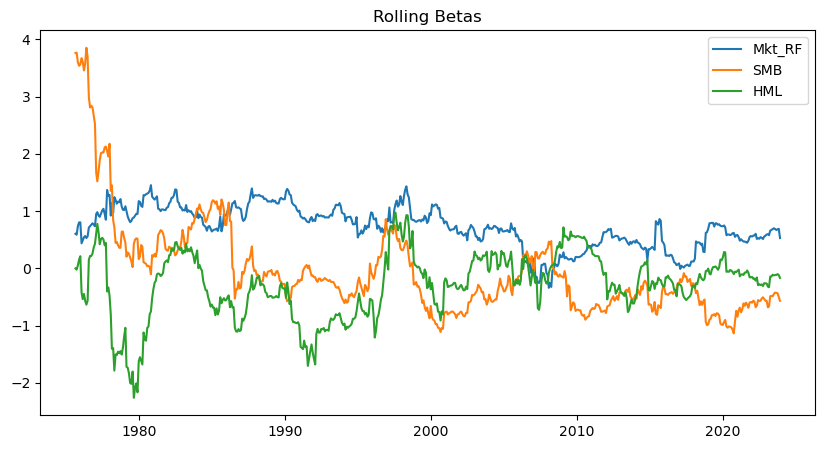

In [35]:
#rolling beta visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(betas['Mkt_RF'], label='Mkt_RF')
plt.plot(betas['SMB'], label='SMB')
plt.plot(betas['HML'], label='HML')
plt.legend(loc='upper right')
plt.title('Rolling Betas')
plt.show()